In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display, display_markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import subprocess as sp
import matplotlib.pyplot as plt
from collections import Counter
from os import path

import logging
logging.getLogger().setLevel(logging.WARNING)

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

sns.set(style='whitegrid')

# Experiment 4
In Experiment 4, we modify an implementation of word2vec (the most widely used word embedding model) so that we can probe the internal state (the embeddings) during training. By computing the embedding projections for our color/adjective pairs during training, we can identify the sentences that are most influential in shaping the relationship between color and adjective.

We compute this by, for each training sample the model sees, taking the distance between the embedding projection in the _current_ state of the model and in the embedding projection in the _final_ state of the model, and correcting this for the previous state of the model and the current learning rate.  
This provides a normalized measure of how much the training sample moved the embedding projection relative to its final state.

In [85]:
tsv_prefix = '../probe_data/'

tsvs = [
    'light_heavy.tsv',
    'relaxed_tense.tsv',
    'alive_dead.tsv',
    'exciting_dull.tsv',
    'soft_hard.tsv',
    'fast_slow.tsv',
    'calm_angry.tsv',
    'ripe_unripe.tsv',
    'fresh_stale.tsv',
    'submissive_aggressive.tsv',
    'active_passive.tsv',
    'selfless_jealous.tsv',
    'cold_hot.tsv',
    'clean_dirty.tsv',
    'like_dislike.tsv',
    'new_old.tsv',
    'happy_sad.tsv',
]

colors = ['red', 'black', 'orange', 'yellow', 'brown', 'green', 'purple', 'white', 'blue']

In [86]:
# read sentences from training corpus
df_sentences = pd.read_csv('../corpora/dedup.all_fic.clean.txt',
                           header=None, na_filter=False, skip_blank_lines=False)

# set index for sentences and rename column
df_sentences['idx'] = range(len(df_sentences))
df_sentences = df_sentences.rename(columns={0: 'text'})
display(df_sentences)

,text,idx
0,p Your grandmother Mr,0
1,So I keep look ing,1
2,Keller took a slip of name and address to memo...,2
3,Invasive procedure or invasive personality The...,3
4,Sitting there at the keyboard he hunched forwa...,4
...,...,...
7260420,Two doors down the hall was her office,7260420
7260421,I mean after all if I m talking to someone who...,7260421
7260422,Responding to the growls a herd of grazing HAD...,7260422
7260423,O Connell OK,7260423


In [87]:
dfs = []
stats = []

# loop over dimension tsvs
for q, tsv in enumerate(tsvs):
    print(f'processing dataframe {q + 1} of {len(tsvs)}')
    
    # read embedding projection data
    df = pd.read_csv(path.join(tsv_prefix, tsv), sep='\t')
    print('read dataframe')
    
    # split dimension
    dimensions = tsv[:-4].split('_')
    
    # select only final epoch (embedding space has stabilized somewhat, more informative data)
    df = df[df['epoch'] == 4]
    
    # merge sentences into embedding projection dataframe
    df = df.merge(df_sentences, how='left', left_on='sentence', right_on='idx')
    print('merged dataframe')
    
    # store reference value for each color (projection at final time point)
    references = {color: df.loc[len(df) - 1, color] for color in colors}

    # get nameability data
    df_names = pd.read_csv('../color-semantics/data/mean_nameability.tsv', sep='\t')
    
    for color, ref in references.items():
        
        # compute distance to reference value (final time point) for each color
        df[color + '_dist'] = np.abs(df[color] - ref)
    
        # compute the absolute percentage change between distance
        # at training sample n and training sample n - 1
        df[color + '_diff'] = df[color + '_dist'].pct_change().abs()
        
        # correct relative change for model learning rate at time point of training sample
        df[color + '_diff_corr'] = df[color + '_diff'] / df['alpha']
        
        # sort sentences by corrected relative difference
        df_sort = df.replace([np.inf, -np.inf], np.nan).dropna().sort_values(color + '_diff_corr', ascending=False)
        
        names = df_names.loc[(df_names['color'] == color) &
                 (df_names['dimension'].isin(dimensions)),
                 'modal_names'].str.split(',').sum()

        scores = []
        count = 0
        count_all = 0
        for i, line in enumerate(df_sort['text'].values):
            if set(names) & set(line.split()):
                count += 1
                count_all += 1
            if i % round(len(df_sort) / 100) == 0:
                scores.append([color, '-'.join(dimensions), i / round(len(df_sort) / 100), count])
                count = 0

        if count_all == 0:
            count_all = 1
            
        df_temp = pd.DataFrame(scores, columns=['color', 'dimension', 'rank_bin', 'mediator_count'])
        df_temp['overall_count'] = count_all
        df_temp['relative_count'] = df_temp['mediator_count'] / count_all
        dfs.append(df_temp)
        
        n_color = df_sort[:1000].apply(lambda row: 1 if color in row['text'] else 0, axis=1).sum()
        n_dim = (df_sort[:1000].apply(lambda row: 1 if dimensions[0] in row['text'] else 0, axis=1).sum() +
                 df_sort[:1000].apply(lambda row: 1 if dimensions[1] in row['text'] else 0, axis=1).sum())
        n_neither = df_sort[:1000].apply(lambda row: 0 if set(dimensions + [color]) &
                                       set(row['text'].split(' ')) else 1, axis=1).sum()
        n_names = df_sort[:1000].apply(lambda row: 1 if set(names) &
                                       set(row['text'].split(' ')) else 0, axis=1).sum()
        
        stats.append(pd.DataFrame({
            'color': [color],
            'dimension': ['-'.join(dimensions)],
            'num_colors': [n_color],
            'num_dims': [n_dim],
            'num_neither': [n_neither],
            'num_labels': [n_names]
        }))

df_counts = pd.concat(dfs)
df_stats = pd.concat(stats)
display(df_stats)

processing dataframe 1 of 17
read dataframe
merged dataframe
processing dataframe 2 of 17
read dataframe
merged dataframe
processing dataframe 3 of 17
read dataframe
merged dataframe
processing dataframe 4 of 17
read dataframe
merged dataframe
processing dataframe 5 of 17
read dataframe
merged dataframe
processing dataframe 6 of 17
read dataframe
merged dataframe
processing dataframe 7 of 17
read dataframe
merged dataframe
processing dataframe 8 of 17
read dataframe
merged dataframe
processing dataframe 9 of 17
read dataframe
merged dataframe
processing dataframe 10 of 17
read dataframe
merged dataframe
processing dataframe 11 of 17
read dataframe
merged dataframe
processing dataframe 12 of 17
read dataframe
merged dataframe
processing dataframe 13 of 17
read dataframe
merged dataframe
processing dataframe 14 of 17
read dataframe
merged dataframe
processing dataframe 15 of 17
read dataframe
merged dataframe
processing dataframe 16 of 17
read dataframe
merged dataframe
processing datafr

,color,dimension,num_colors,num_dims,num_neither,num_labels
0,red,light-heavy,379,819,0,779
0,black,light-heavy,297,772,0,91
0,orange,light-heavy,85,955,0,47
0,yellow,light-heavy,156,900,0,24
0,brown,light-heavy,162,890,0,3
...,...,...,...,...,...,...
0,brown,happy-sad,249,772,0,6
0,green,happy-sad,377,640,0,1
0,purple,happy-sad,87,923,0,1
0,white,happy-sad,469,545,0,84


In [88]:
df_stats.to_csv('data/first_1000_stats.tsv', sep='\t', index=False)
df_counts.to_csv('data/mediator_counts.tsv', sep='\t', index=False)

## Descriptive stats for the number of color- and adjective-containing sentences in the top 1000 most informative sentences for each color/dimension pair
We've counted the number of occurrences of the color and adjective words in the top 1000 most informative sentences for each color/dimension pair, so we can compute some simple descriptive statistics for these counts and report these in the manuscript.

In [98]:
display(df_stats.describe().round(2))

,num_colors,num_dims,num_neither,num_labels
count,153.00,153.00,153.00,153.00
mean,470.45,557.95,0.18,127.75
std,301.16,315.82,0.60,239.51
min,23.00,36.00,0.00,0.00
25%,209.00,233.00,0.00,13.00
50%,418.00,611.00,0.00,34.00
75%,775.00,819.00,0.00,68.00
max,967.00,1045.00,4.00,981.00


In [3]:
df_counts = pd.read_csv('data/mediator_counts.tsv', sep='\t')
display(df_counts)

,color,dimension,rank_bin,mediator_count,overall_count,relative_count
0,red,light-heavy,0.0,1,175565,0.000006
1,red,light-heavy,1.0,58696,175565,0.334326
2,red,light-heavy,2.0,4162,175565,0.023706
3,red,light-heavy,3.0,1146,175565,0.006527
4,red,light-heavy,4.0,1168,175565,0.006653
...,...,...,...,...,...,...
15386,blue,happy-sad,96.0,326,34375,0.009484
15387,blue,happy-sad,97.0,314,34375,0.009135
15388,blue,happy-sad,98.0,325,34375,0.009455
15389,blue,happy-sad,99.0,314,34375,0.009135


In [9]:
df_counts_filtered = df_counts[df_counts['mediator_count'] != 1]

In [5]:
df_counts_filtered = df_counts[df_counts['rank_bin'] != 0]
display(df_counts_filtered)

,color,dimension,rank_bin,mediator_count,overall_count,relative_count
1,red,light-heavy,1.0,58696,175565,0.334326
2,red,light-heavy,2.0,4162,175565,0.023706
3,red,light-heavy,3.0,1146,175565,0.006527
4,red,light-heavy,4.0,1168,175565,0.006653
5,red,light-heavy,5.0,1176,175565,0.006698
...,...,...,...,...,...,...
15386,blue,happy-sad,96.0,326,34375,0.009484
15387,blue,happy-sad,97.0,314,34375,0.009135
15388,blue,happy-sad,98.0,325,34375,0.009455
15389,blue,happy-sad,99.0,314,34375,0.009135


## Plotting the relative prevalence of salient label words in the most informative training sentences (by percentile)
We've compute the impact of each training sentence on each color/adjective pair's embedding projection, but before visualizing those data we're binning them by percentile. We can then count which percentage of salient labels (from the total number in the corpus) occurs in each percentile of informativeness.

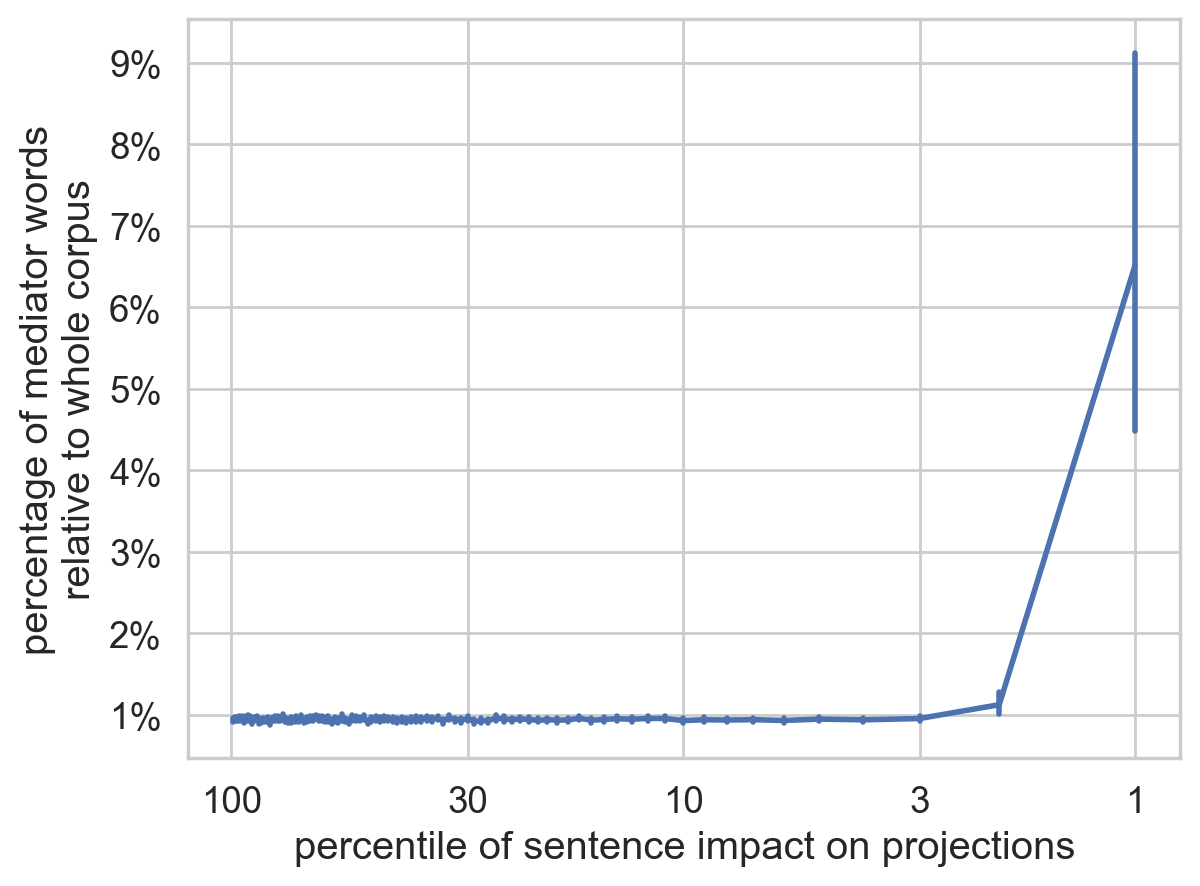

In [16]:
sns.set(style='whitegrid', font_scale=1.2)
df_counts_mean = df_counts_filtered.groupby(['color', 'dimension','rank_bin']).mean().reset_index()
df_counts_mean['informative_pct'] = df_counts_mean['relative_count'] * 100

ax = sns.lineplot(
    data=df_counts_mean[df_counts_mean['rank_bin'] < 100],
    x='rank_bin',
    y='informative_pct',
    err_style='bars',
    errorbar=('ci', 95),
    err_kws={'elinewidth': 2},
    lw=2,
)
ax.set(
    ylabel='percentage of mediator words\nrelative to whole corpus',
    xlabel='percentile of sentence impact on projections',
    #title='occurrence of mediator words in sentences\nmost informative for embedding projections',
    yticks=[1, 2, 3, 4, 5, 6, 7, 8, 9],
    yticklabels=['1%', '2%', '3%', '4%', '5%', '6%', '7%', '8%', '9%'],
    xscale='log',
    xticks=[1, 3, 10, 30, 100],
    xticklabels=[1, 3, 10, 30, 100],
)
ax.invert_xaxis()
ax.grid(True)
plt.savefig('figures/mediator_prevalence_by_colordim.pdf', bbox_inches='tight')

## Training sample informativeness, split by color, dimension, and color/dimension

/Users/jvparidon/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


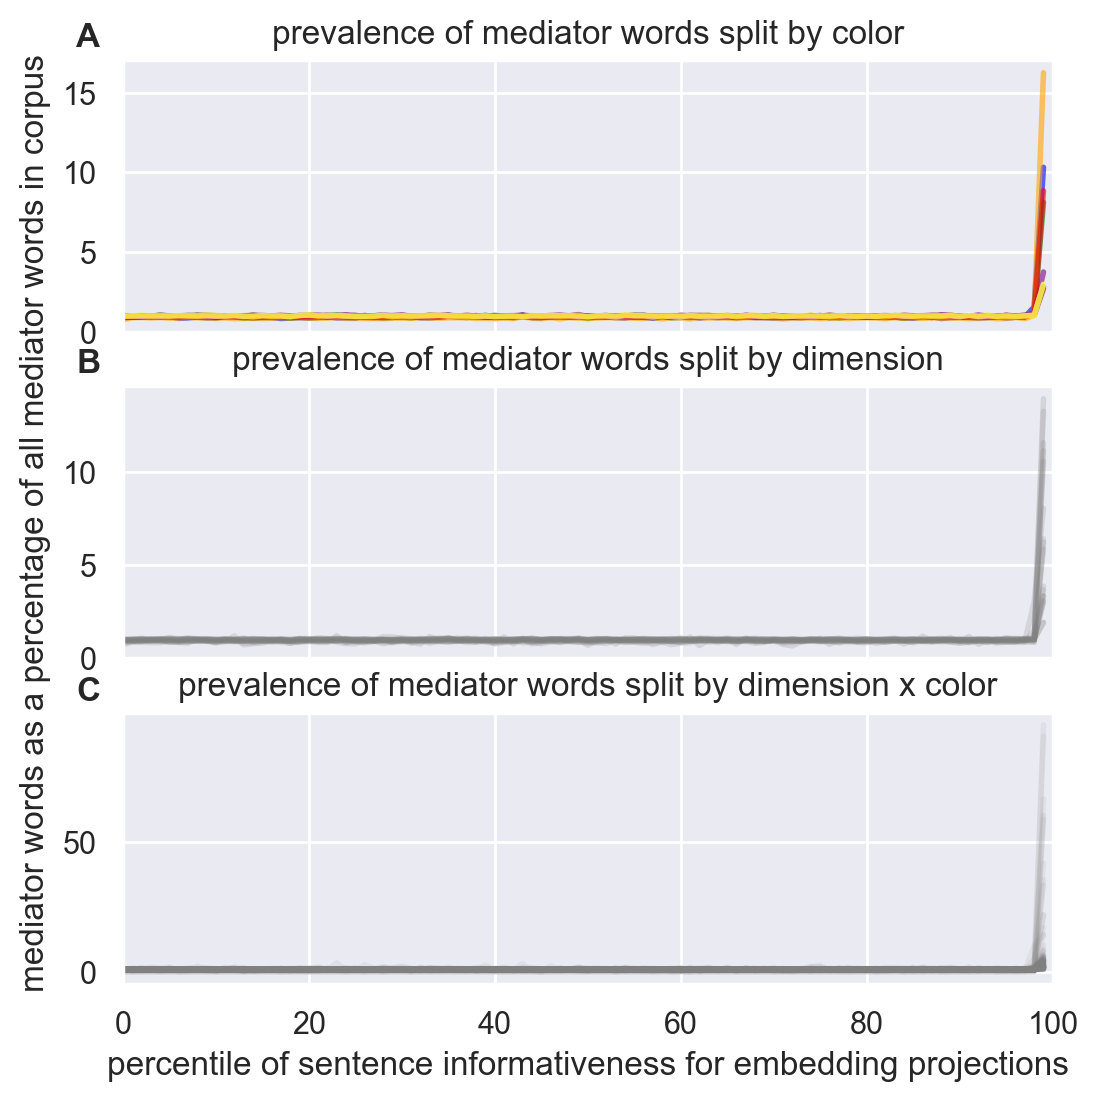

In [12]:
sns.set(style='darkgrid', context='notebook')

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(3, 1, 1)

df_counts_mean = df_counts_filtered.groupby(['color', 'rank_bin']).mean().reset_index()
df_counts_mean['log_relative_count'] = np.log10(df_counts_mean['relative_count'])
df_counts_mean['rel_count_pct'] = df_counts_mean['relative_count'] * 100
df_counts_mean['log_rank'] = np.log10(df_counts_mean['rank_bin'])
df_counts_mean['rank_pct'] = 100 - (df_counts_mean['rank_bin'] / df_counts_mean['rank_bin'].max()) * 100

palette = {color: color for color in df_counts_mean['color'].unique()}

ax1 = sns.lineplot(
    data=df_counts_mean[df_counts_mean['rank_bin'] != 0],
    hue='color',
    x='rank_pct',
    y='rel_count_pct',
    alpha=.6,
    lw=2,
    palette=palette,
)
ax1.set(
    ylabel='',
    xlabel='',
    title='prevalence of mediator words split by color',
    xticklabels='',
    xlim=[0, 100],
)
ax1.get_legend().remove()
ax1.text(-5, df_counts_mean['rel_count_pct'].max() * 1.1, 'A', weight='bold')


ax2 = fig.add_subplot(3, 1, 2)
df_counts_mean = df_counts_filtered.groupby(['dimension', 'rank_bin']).mean().reset_index()
df_counts_mean['log_relative_count'] = np.log10(df_counts_mean['relative_count'])
df_counts_mean['rel_count_pct'] = df_counts_mean['relative_count'] * 100
df_counts_mean['log_rank'] = np.log10(df_counts_mean['rank_bin'])
df_counts_mean['rank_pct'] = 100 - (df_counts_mean['rank_bin'] / df_counts_mean['rank_bin'].max()) * 100

ax2 = sns.lineplot(
    data=df_counts_mean[df_counts_mean['rank_bin'] != 0],
    hue='dimension',
    x='rank_pct',
    y='rel_count_pct',
    alpha=.2,
    lw=2,
    palette=['gray'] * len(df_counts_mean['dimension'].unique()),
)
ax2.set(
    ylabel='mediator words as a percentage of all mediator words in corpus',
    xlabel='',
    title='prevalence of mediator words split by dimension',
    xticklabels='',
    xlim=[0, 100],
)
ax2.get_legend().remove()
ax2.text(-5, df_counts_mean['rel_count_pct'].max() * 1.1, 'B', weight='bold')


ax3 = fig.add_subplot(3, 1, 3)
df_counts_mean = df_counts_filtered.groupby(['color', 'dimension', 'rank_bin']).mean().reset_index()
df_counts_mean['log_relative_count'] = np.log10(df_counts_mean['relative_count'])
df_counts_mean['rel_count_pct'] = df_counts_mean['relative_count'] * 100
df_counts_mean['log_rank'] = np.log10(df_counts_mean['rank_bin'])
df_counts_mean['rank_pct'] = 100 - (df_counts_mean['rank_bin'] / df_counts_mean['rank_bin'].max()) * 100
df_counts_mean['colordim'] = df_counts_mean['color'] + '-' + df_counts_mean['dimension']

ax3 = sns.lineplot(
    data=df_counts_mean[df_counts_mean['rank_bin'] != 0],
    hue='colordim',
    x='rank_pct',
    y='rel_count_pct',
    alpha=.1,
    lw=2,
    palette=['gray'] * len(df_counts_mean['colordim'].unique()),
)
ax3.set(
    ylabel='',
    xlabel='percentile of sentence informativeness for embedding projections',
    title='prevalence of mediator words split by dimension x color',
    xlim=[0, 100],
)
ax3.get_legend().remove()
ax3.text(-5, df_counts_mean['rel_count_pct'].max() * 1.1, 'C', weight='bold')
plt.savefig('figures/mediator_prevalence_all.pdf')

# Convert notebook to html

In [17]:
convert_notebook('experiment_4')

[NbConvertApp] Converting notebook experiment_4.ipynb to html
[NbConvertApp] Writing 967244 bytes to experiment_4.html


Jupyter notebook `experiment_4` converted successfully.